In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns
from IPython.display import Image, display
from scipy.optimize import minimize
%config InlineBackend.figure_format = 'retina'

# Read in historical data

In [3]:
df = pd.read_csv('ETFs.csv')
cols = ["date","AGG","SPY"]
df = df[cols]
df = df.rename(columns={"AGG":"Bond","GLD":"Commodity","SPY":"Equity","date":"date"})
df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")
df = df.dropna()
df.set_index('date', inplace=True)

In [4]:
df = df.unstack().to_frame("price").reset_index().rename(columns={"level_0":"asset_id"})

In [12]:
ret = df.pivot_table(index='date', values='price', columns='asset_id').pct_change().unstack().to_frame('return').reset_index()

In [14]:
df = df.merge(ret, on=['date', 'asset_id'], how='left')

In [15]:
df

,asset_id,date,price,return
0,Bond,2003-09-26,70.5699,NaN
1,Bond,2003-09-29,70.3770,-0.002733
2,Bond,2003-09-30,70.7421,0.005188
3,Bond,2003-10-01,70.7077,-0.000486
4,Bond,2003-10-02,70.5974,-0.001560
5,Bond,2003-10-03,70.0877,-0.007220
6,Bond,2003-10-06,70.1910,0.001474
7,Bond,2003-10-07,69.9500,-0.003433
8,Bond,2003-10-08,70.1222,0.002462
9,Bond,2003-10-09,69.8742,-0.003537


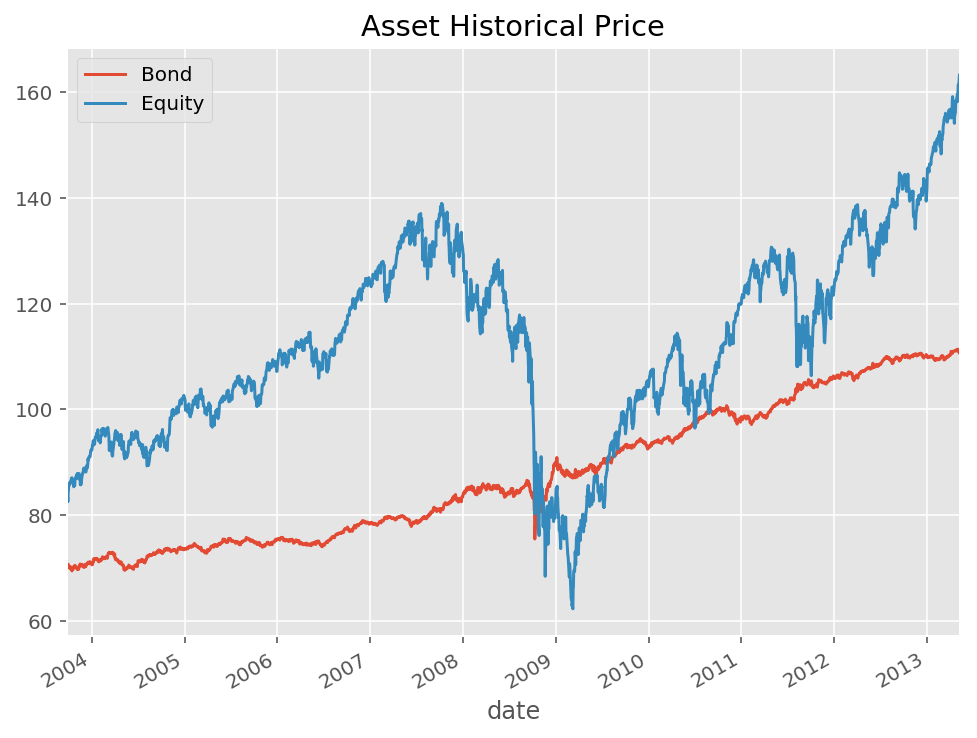

In [159]:
df.plot(figsize=(8, 6), title='Asset Historical Price');

### correlation matrix of percentage return between assets

In [160]:
pct_return.corr().round(2)

,Bond,Equity
Bond,1.00,-0.11
Equity,-0.11,1.00


# Simple Risk Parity

* Assume no correlation among assets, so that weight of asset is 1/(asset_volatility)

Use **half-life** to compute asset volatility

In [26]:
volatility = (df.pivot_table(values='return', index='date', columns='asset_id')
                      .rolling(window=60).std()*np.sqrt(252))

In [37]:
vol = volatility.unstack().to_frame('vol').reset_index()

df = df.merge(vol, on=['date', 'asset_id'], how='left')
df

,asset_id,date,price,return,vol
0,Bond,2003-09-26,70.5699,NaN,NaN
1,Bond,2003-09-29,70.3770,-0.002733,NaN
2,Bond,2003-09-30,70.7421,0.005188,NaN
3,Bond,2003-10-01,70.7077,-0.000486,NaN
4,Bond,2003-10-02,70.5974,-0.001560,NaN
5,Bond,2003-10-03,70.0877,-0.007220,NaN
6,Bond,2003-10-06,70.1910,0.001474,NaN
7,Bond,2003-10-07,69.9500,-0.003433,NaN
8,Bond,2003-10-08,70.1222,0.002462,NaN
9,Bond,2003-10-09,69.8742,-0.003537,NaN


In [38]:
df['weights'] = 1/df['vol']
df

,asset_id,date,price,return,vol,weights
0,Bond,2003-09-26,70.5699,NaN,NaN,NaN
1,Bond,2003-09-29,70.3770,-0.002733,NaN,NaN
2,Bond,2003-09-30,70.7421,0.005188,NaN,NaN
3,Bond,2003-10-01,70.7077,-0.000486,NaN,NaN
4,Bond,2003-10-02,70.5974,-0.001560,NaN,NaN
5,Bond,2003-10-03,70.0877,-0.007220,NaN,NaN
6,Bond,2003-10-06,70.1910,0.001474,NaN,NaN
7,Bond,2003-10-07,69.9500,-0.003433,NaN,NaN
8,Bond,2003-10-08,70.1222,0.002462,NaN,NaN
9,Bond,2003-10-09,69.8742,-0.003537,NaN,NaN


In [43]:
df['weights'] = df[['asset_id','date','weights']].groupby('date')['weights'].transform(lambda x: x/x.sum())

In [48]:
df

,asset_id,date,price,return,vol,weights
0,Bond,2003-09-26,70.5699,NaN,NaN,NaN
1,Bond,2003-09-29,70.3770,-0.002733,NaN,NaN
2,Bond,2003-09-30,70.7421,0.005188,NaN,NaN
3,Bond,2003-10-01,70.7077,-0.000486,NaN,NaN
4,Bond,2003-10-02,70.5974,-0.001560,NaN,NaN
5,Bond,2003-10-03,70.0877,-0.007220,NaN,NaN
6,Bond,2003-10-06,70.1910,0.001474,NaN,NaN
7,Bond,2003-10-07,69.9500,-0.003433,NaN,NaN
8,Bond,2003-10-08,70.1222,0.002462,NaN,NaN
9,Bond,2003-10-09,69.8742,-0.003537,NaN,NaN


In [162]:
weights = 1/df_std
# to make sure sum of all asset weights equal to 1:
row_sum = (1/df_std).sum(axis=1)
weights = weights.apply(lambda x: x/row_sum)

In [163]:
# portfolio return per day
portf_return = (pct_return*weights.shift(1)).sum(1)
# random portfolio percentage (for 3 asset classes only)
n = pct_return.shape[1]
portf_return_static = pct_return.dot(np.array([1/n]*n))

In [194]:
#m1
df_ret = pct_return.unstack().reset_index()
df_ret.columns = ["asset_id", "date", "asset_return"]

df_wt = weights.shift(1).unstack().reset_index()
df_wt.columns = ["asset_id", "date", "weight"]

df = df_ret.merge(df_wt, on = ["date", "asset_id"]).dropna()

portf_return = (df
                .groupby("date")
                .apply(lambda x: (x["weight"]*x["asset_return"]).sum())
                .to_frame("port_ret"))


#m2
pct_return.join(weights.shift(1), lsuffix="_ret", rsuffix="_wt")

#m3
pct_return*weights.shift(1)

,Bond,Equity
date,,
2003-09-26,NaN,NaN
2003-09-29,NaN,NaN
2003-09-30,NaN,NaN
2003-10-01,NaN,NaN
2003-10-02,NaN,NaN
2003-10-03,NaN,NaN
2003-10-06,NaN,NaN
2003-10-07,NaN,NaN
2003-10-08,NaN,NaN


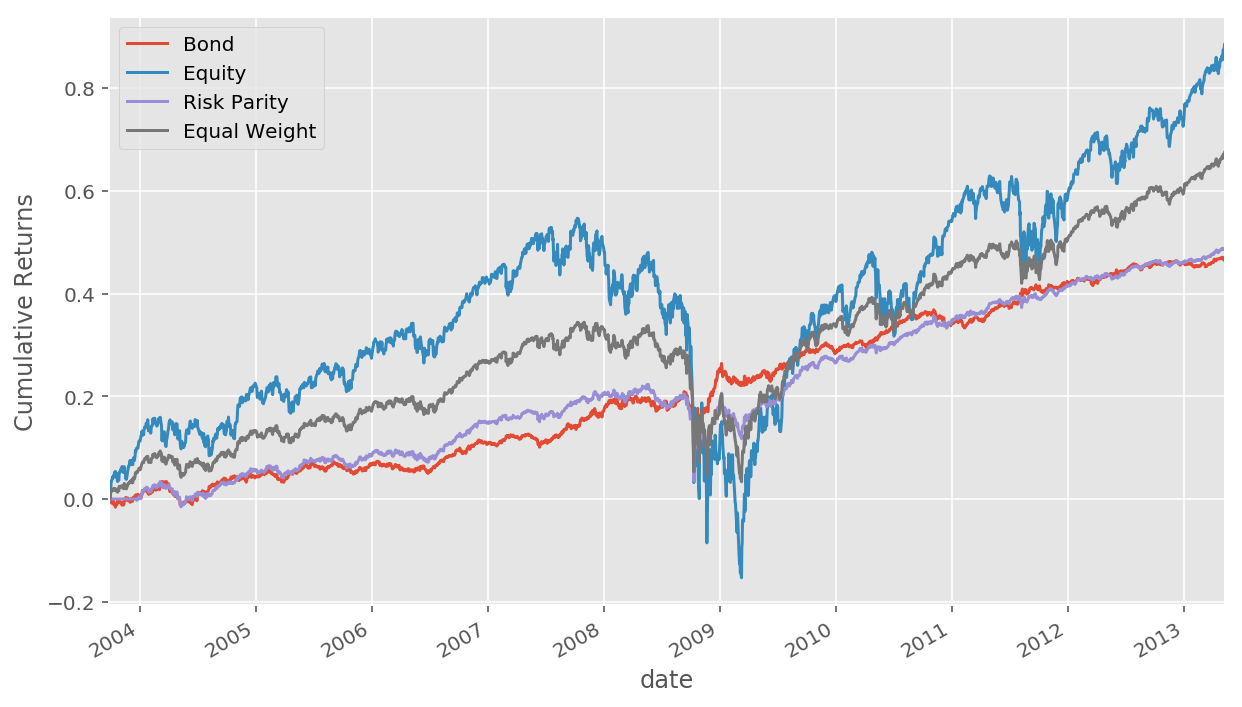

In [164]:
ax = pct_return.cumsum().plot(figsize=(10, 6))
portf_return.cumsum().to_frame('Risk Parity').plot(ax=ax)
portf_return_static.to_frame('Equal Weight').cumsum().plot(ax=ax)

ax.set_ylabel('Cumulative Returns');

In [165]:
return_all_portf = (pct_return
                    .join(portf_return.to_frame('Risk Parity'))
                    .join(portf_return_static.to_frame('Equal Weight')))

In [166]:
def get_summary(df_return):
    # average annual return
    ann_return = df_return.mean()*252
    # volatility of all assets&portfolios
    ann_vol = df_return.std()*np.sqrt(252)
    sharpe = ann_return/ann_vol
    summary = pd.DataFrame({"ann_return (%)":ann_return*1e2, 
                            "ann_vol (%)":ann_vol*1e2,
                            "sharpe":sharpe}).round(2)
    return summary

In [167]:
summary = get_summary(return_all_portf)

In [168]:
summary

,ann_return (%),ann_vol (%),sharpe
Bond,4.84,5.40,0.90
Equity,9.20,20.63,0.45
Risk Parity,5.06,5.84,0.87
Equal Weight,7.02,10.38,0.68


### Calculate weight contribution

In [169]:
pct_risk_contrib = weights*0
weighting_scheme = 'NRP'

In [170]:
for i in range(len(weights)):
    if i >= 60:
        weights_vect = weights.iloc[i]
        Sigma = pct_return.iloc[i-60:i,:].cov()
        var_p = weights_vect.dot(Sigma).dot(weights_vect)
        risk_contribution_vect = (weights_vect*(Sigma.dot(weights_vect)))/var_p
        pct_risk_contrib.iloc[i,:] = np.array(risk_contribution_vect)

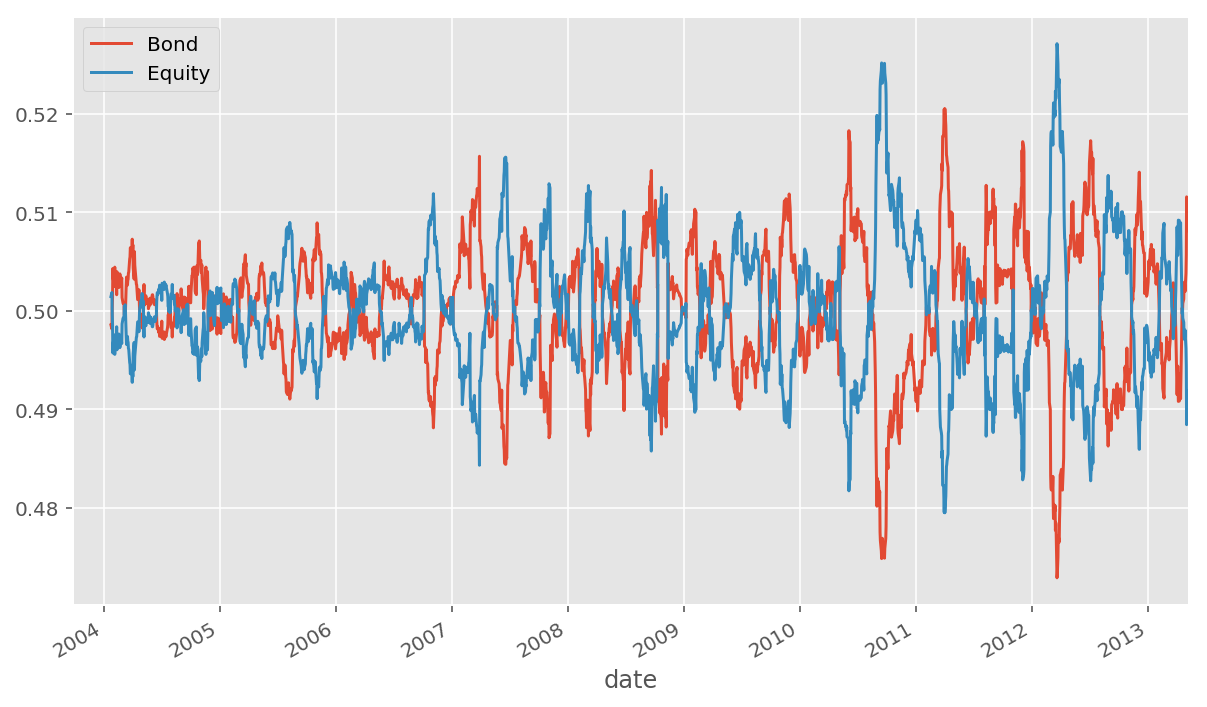

In [171]:
pct_risk_contrib.rolling(window=22).mean().plot(figsize=(10,6))